In [1]:
# the purpose of this notebook is to test an analytical solution for my model
# for the special case where sediment supply is infinite (H >> H*)
# and attrition occurs on sediment
# a derivation is below

$$\frac{\partial z}{\partial t} = U - \frac{1}{(1-\phi)B} \left(\frac{\partial Q_s}{\partial x} + \beta Q_s \right)$$

> This says that in a world with no bedrock abrasion, changes in profile elevation depend only on uplift and sediment processes (sediment divergence and attrition that degrades the bed material).

>> <i>Note that the full form of the above equation is: </i>

>>$$\frac{\partial z}{\partial t} = U - \frac{1}{(1-\phi)B} \left(\frac{\partial Q_s}{\partial x} + \beta Q_s - q_L - E_p\right)$$

>> <i>where $q_L$ is the lateral sediment influx and $E_p$ denotes erosion from plucking. Since no bedrock is exposed and available to be plucked, $E_p = 0$. Likewise, the lateral sediment input rate is calculated by applying the bedrock erosion rate over the full width of the drainage basin; again, since no bedrock is exposed, this rate is assumed to be $0$.</i> <B><I>IS THIS RIGHT?</B></I>

> If we assume a steady state condition $\left( \frac{\partial z}{\partial t} = 0 \right )$, then the first equation above simplifies to:

$$U = \frac{1}{(1-\phi)B} \left(\frac{\partial Q_s}{\partial x} + \beta Q_s \right)$$

> First we want to eliminate the derivative, so isolate that piece:

$$\frac{\partial Q_s}{\partial x} = UB(1-\phi) - \beta Q_s$$

>integrate with respect to $x$:

$$Q_s = UBx(1-\phi) - \beta Q_s x$$

> Now isolate $Q_s$:

$$Q_s + \beta Q_s x = UBx(1-\phi)$$

$$Q_s (1 + \beta x) = UBx(1-\phi)$$

$$Q_s = \frac{UBx(1-\phi)}{(1 + \beta x)}$$

> Replace $Q_s$ with full formulation from Wickert & Schildgen:

$$k_{Qs}IQS^{7/6} = \frac{UBx(1-\phi)}{(1 + \beta x)}$$

> And rearrange:

$$S^{7/6} = \frac{UBx(1-\phi)}{(1 + \beta x)} \frac{1}{k_{Qs}IQ}$$

> Isolate $S$:

$$S = \left(\frac{UBx(1-\phi)}{(1 + \beta x)} \frac{1}{k_{Qs}IQ}\right)^{6/7}$$

This could be condensed and simplified a bit more, but this is fine for testing purposes. Check it out below.

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# now set up arrays and parameters
dx = 1000 # grid spacing
x = np.arange(0, 5000, dx) # domain length

# H = 100 + np.zeros(len(x)) # sediment thickness
# z = np.linspace(1, 0.1, len(x)) # + H # need to start with slight bedrock slope
z = np.zeros(len(x))

U = 0.0001 # uplift rate
phi = 0.55 # sediment porosity
kqs = 0.041 # sediment discharge coefficient
I = 0.01 # intermittency factor
r = 10. # runoff rate
kxb = 25 # valley width coeffecient
Pxb = 1/5 # valley width exponent
beta = 0.004
# Hstar = 0.1 # characteristic sediment thickness

B = kxb * (x**Pxb) # valley width 
Q = (5./6.) * r * kxb * x**(6./5.) # total discharge

In [4]:
# now solve for predicted steady state slope
slope_pred = ((U * B[1:] * x[1:] * (1 - phi))/(1 + (beta * x[1:])) * 1/(kqs*I*Q[1:]))**(6/7)
slope_pred_exp = ((6./5.) * ((U * (1 - phi))/(beta * kqs * I * r * x[1:])) * (1 - np.exp(-beta * x[1:])))**(6./7.)

# okay, now make a line using that constant slope
y = -slope_pred * x[1:]

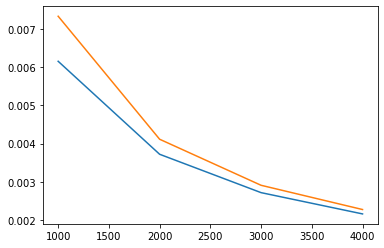

In [5]:
plt.plot(x[1:], slope_pred)
plt.plot(x[1:], slope_pred_exp)

In [6]:
# great, the prediction looks good
# concavity increases as beta increases
# now to test the numerical solution

In [7]:
x[4]

4000

In [8]:
def all_sed_attrition(dx, x, z, U, phi, kqs, I, r, kxb, Pxb, beta, B, Q, num_steps=7000000):
    
    # set timestep
    dt = (0.5 * dx * dx / (kqs*Q[-1]))
    
    # create arrays
    Qs = np.zeros(len(x))
    E = np.zeros(len(x))
    dzdt = np.zeros(len(x))
    
    # set boundary conditions
    Qs[0] = 0
    E[-1] = 0
    dzdt[-1] = 0
    
    # track uplift
    total_dzdt = 0
    
    for i in range(num_steps):
        
        # calculate slope
        S = np.abs(np.diff(z)/dx)
        
        # calculate sediment transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.)
        
        # calculate erosion
        E[:-1] = (1/((1-phi)*B[1:])) * (np.diff(Qs)/dx + (beta * Qs[1:]))
        
        # calculate change in elevation
        dzdt[:-1] = U - E[:-1]
        
        # update profile
        z[:] += dzdt * dt
        
        # track total change in elev so we can account for this when comparing to prediction
        total_dzdt += dzdt * dt
        
    cum_time = num_steps * dt
    print(cum_time)
        
    return (S, Qs, E, dzdt, z, dt, total_dzdt)

In [9]:
# now write a test
test = [dx, x, z, U, phi, kqs, I, r, kxb, Pxb, beta, B, Q]

# and run it
slope, Qs, E, dzdt, model_z, dt, total_dzdt = all_sed_attrition(*test)

19500845.22586998


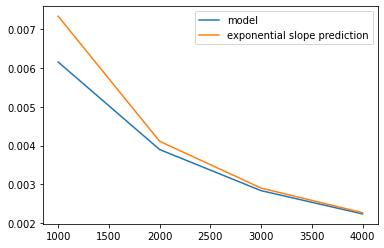

In [10]:
plt.plot(x[1:], slope, label = 'model')
plt.plot(x[1:], slope_pred_exp, label = 'exponential slope prediction')
# plt.plot(x[1:], slope_pred_fixed, label = 'fixed width prediction')
plt.legend()

In [11]:
E

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 0.e+00])

In [12]:
predicted_topo = -(slope_pred_exp * x[1:])
model_topo = - slope * x[1:]
baselevel_diff = model_topo - predicted_topo

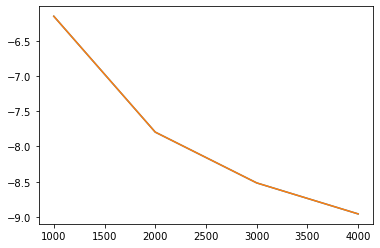

In [13]:
plt.plot(x[1:], predicted_topo + baselevel_diff)
plt.plot(x[1:], model_topo)

In [14]:
# re-doing derivation below

Start with conservation of mass of sediment in a landscape "cell":
> $$\frac{\partial M}{\partial t} = \text{Mass in} - \text{Mass out}$$

We envision a world with unlimited sediment supply and attrition occurring on grains in transport. The cell has height $z$, total width $B$, and length $dx$. Contained within the cell is a of channel width $b$. The sediment has porosity $\phi$ and density $\rho$. The cell is experiencing uniform uplift $U$. Mass is added via sediment flux into the cell, as well as tectonic uplift into the cell. Mass is lost via sediment flux out of the cell, and grain attrition generating fines within the cell. Putting all these pieces together, we arrive at:
> $$\frac{\partial z B (1 - \phi) dx \rho}{\partial t} = U B dx \rho + Q_s\bigr\rvert_{x} \rho - Q_s\bigr\rvert_{x + \Delta x} \rho - \frac{Q_s}{B} \beta B dx \rho $$

We can remove the constants from the partial derivative and bring them to the RHS of the equation:
> $$\frac{\partial z}{\partial t} = \frac{U B dx \rho}{B (1 - \phi) dx \rho} + \frac{Q_s\bigr\rvert_{x} \rho}{B (1 - \phi) dx \rho} - \frac{Q_s\bigr\rvert_{x + \Delta x} \rho}{B (1 - \phi) dx \rho} - \frac{Q_s \beta B dx \rho}{B B (1 - \phi) dx \rho} $$

Simplfy and pull out a common denominator:
> $$\frac{\partial z}{\partial t} = \frac{1}{(1 - \phi) B} \left( U B + \frac{Q_s\bigr\rvert_{x}}{dx} - \frac{Q_s\bigr\rvert_{x + \Delta x}}{dx} - Q_s \beta \right)$$

Rewrite the sediment flux pieces as a derivative:
> $$\frac{\partial z}{\partial t} = - \frac{1}{(1 - \phi) B} \left( \frac{\partial Q_s}{\partial x} + Q_s \beta - U B \right)$$

At steady state, change in sediment thickness is 0:
> $$0 = - \frac{1}{(1 - \phi) B} \left( \frac{\partial Q_s}{\partial x} + Q_s \beta - U B \right)$$

Go about solving for $S$ in terms of $x$. $S$ lives within $Q_s$, so first we need to isolate $Q_s$:
> $$\frac{\partial Q_s}{\partial x} = UB -  Q_s \beta$$

> $$d Q_s = UBdx -  Q_s \beta dx$$

> $$\int_{0}^{Q_s} d Q_s = \int_{0}^{x} UB dx - \int_{0}^{x} Q_s \beta dx$$